 # Introduction
 Setting up the notebook to run XAI methods on the case studies.

In [1]:
! git clone https://github.com/nikodallanoce/XAI_PhD_prj.git
! git clone https://github.com/pellungrobe/XAI_course_2024.git

Cloning into 'XAI_PhD_prj'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 90 (delta 27), reused 19 (delta 5), pack-reused 21
Receiving objects: 100% (90/90), 160.11 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (16/16), done.
Cloning into 'XAI_course_2024'...
remote: Enumerating objects: 4098, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 4098 (delta 30), reused 36 (delta 26), pack-reused 4050
Receiving objects: 100% (4098/4098), 1006.87 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (450/450), done.
Updating files: 100% (3055/3055), done.


In [2]:
! pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 64.1 MB/s eta 0:00:00


In [3]:
! gdown --fuzzy https://drive.google.com/file/d/1cgEKSkQ-LQX4VYa-oRliY0W6B3XsQKAi/view?usp=sharing
! 7z x -aos "/content/New Plant Diseases Dataset(Augmented).zip" #contains only validation and test set.

Downloading...
From (original): https://drive.google.com/uc?id=1cgEKSkQ-LQX4VYa-oRliY0W6B3XsQKAi
From (redirected): https://drive.google.com/uc?id=1cgEKSkQ-LQX4VYa-oRliY0W6B3XsQKAi&confirm=t&uuid=1011164b-30d8-4d75-89a8-bb7b4c92ca6a
To: /content/New Plant Diseases Dataset(Augmented).zip
100% 289M/289M [00:16<00:00, 17.8MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 289378688 bytes (276 MiB)

Extracting archive: /content/New Plant Diseases Dataset(Augmented).zip
 23% 4096 Open              --
Path = /content/New Plant Diseases Dataset(Augmented).zip
Type = zip
Physical Size = 289378688

  0%      1% 406          3% 645 - New Plant Diseases Dataset(Au . 5e___JR_FrgE.S

In [4]:
from XAI_PhD_prj.CustomEfficientNet import CustomEfficientNet
import lightning.pytorch as pl
from tqdm.auto import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "XAI_course_2024") # to import xailib

torch.set_float32_matmul_precision('medium')

In [5]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

model = CustomEfficientNet.load_from_checkpoint("/content/XAI_PhD_prj/checkpoints/efficient_net_scratch-v15.ckpt")
model.eval()
model.to(device)
model.freeze()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [6]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

data_dir = "New Plant Diseases Dataset(Augmented)"
valid_dir = os.path.join(data_dir, "valid")
batch_size = 32
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())
valid_dl = DataLoader(valid, batch_size, num_workers=4, pin_memory=True, persistent_workers=True)
test_dir = os.path.join(data_dir, "test")
test = ImageFolder(test_dir, transform=transforms.ToTensor())
for k in test.class_to_idx:
    test.class_to_idx[k] = valid.class_to_idx[k]
test.samples = test.make_dataset(test_dir, test.class_to_idx,
                                 extensions=(
                                     ".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"))
test_dl = DataLoader(test, batch_size, num_workers=4, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
idx_to_disease =  {v:k for k,v in valid.class_to_idx.items()}
dict_path_to_class = {k:v for k,v in valid.samples} # dict to associate the path to the label (idx)

#CASE 1: Misclassified Images
In this case we analyze the case of Misclassified Examples.


In [8]:
# Load the JSON file that contained the misclassified as a dictionary
import json
with open("XAI_PhD_prj/json/miss_classified_images.json") as json_file:
    miss_classified_images = json.load(json_file)

for item in miss_classified_images:
    item['img'] = valid[item['img_idx']][0]
    #assert item['img'][1] == item['label']

**Confusion matrix of misclassified examples**

Here we visualize the confusion matrix of misclassified example, to investigate their behaviour

In [9]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store labels and predictions
all_labels = []
all_preds = []

# Iterate through mis_classified_images and extract labels and predictions
for entry in miss_classified_images:
    all_labels.append(entry["label"])
    all_preds.append(entry["prediction"])

# Convert lists to tensors
all_labels_tensor = torch.tensor(all_labels)
all_preds_tensor = torch.tensor(all_preds)

confmat = ConfusionMatrix(num_classes=len(valid.classes), task='multiclass')

# Update the confusion matrix with all labels and predictions
confmat.update(all_preds_tensor, all_labels_tensor)

# Get the confusion matrix as a numpy array
conf_matrix_np = confmat.compute().numpy()

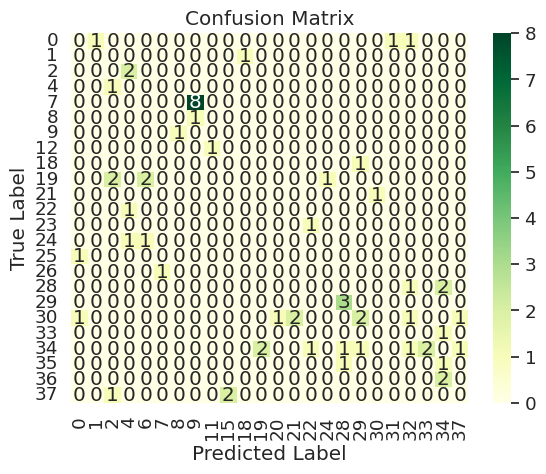

In [ ]:
# Remove all the rows and columns having all zeros.
# We do not take into account classes not having misclassified images

nz_rows, nz_columns = np.nonzero(conf_matrix_np)
data = conf_matrix_np.copy()
data = data[~np.all(data == 0, axis=1)]
data = data.T
data = data[~np.all(data == 0, axis=1)]
data = data.T

xticklabels=[str(x) for x in np.unique(nz_columns)]
yticklabels=[str(x) for x in np.unique(nz_rows)]

sns.set(font_scale=1.2)  # Adjust font scale if necessary
sns.heatmap(data, annot=True, cmap="YlGn", xticklabels=xticklabels, yticklabels=yticklabels)
plt.xticks(rotation = 90)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix we have seen that the model missclassified 8 examples of class 7 (Corn_(maize)_Cercospora_leaf_spot) as class 9 (Corn_(maize)_Northern_Leaf_Blight), which suggest that the model have some difficulties to recognize certain images of class 7.
We now try to use explainability to understand what are the part of the images that leads to this misclassification. To do this we analyze:
- One of the missclassified example
- One element of class 7
- One element of class 9

In [ ]:
from PIL import Image
#dictionary where the path are stored

def take_one_image(path):
    img = Image.open(path)
    convert_tensor = transforms.ToTensor()
    img = convert_tensor(img)
    img = img.to(device)  # Move the input tensor to the same device as the model

    # Ensure model is on the same device as the input tensor
    model.to(device)

    # Pass the input tensor through the model
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        probs = model(img.unsqueeze(0).float())
        classes = torch.argmax(probs, dim=1)

    return img, probs, classes

# Function to collect paths of images of a precise class
def get_paths_by_class(image_class_dict, target_class):
    paths = []
    for path, label in image_class_dict.items():
        if label == target_class:
            paths.append(path)
    return paths


In [ ]:
#select misclassified image
miss_classified_instance = miss_classified_images[14]['img']
probs_mis = model(miss_classified_instance.unsqueeze(0))

In [ ]:
#Select images from the 2 classes
paths_of_class_7 = get_paths_by_class(dict_path_to_class, 7)
paths_of_class_9 = get_paths_by_class(dict_path_to_class,9)
img_class_7, probs_7, classes_7 = take_one_image(paths_of_class_7[33])
img_class_9, probs_9, classes_9 = take_one_image(paths_of_class_9[13])

In [ ]:
print('We have an image from class 7 with prediction class', int(classes_7),'and predicion probability', float(torch.nn.functional.softmax(probs_7,dim=1)[0,int(classes_7)]))
print('We have an image from class 9 with prediction class', int(classes_9),'and predicion probability', float(torch.nn.functional.softmax(probs_9,dim=1)[0,int(classes_9)]))
print('We have an image from class 7 misclassified as 9 with prediction probability', float(torch.nn.functional.softmax(probs_mis,dim=1)[0,int(classes_9)]))

We have an image from class 7 with prediction class 7 and predicion probability 0.9061458706855774
We have an image from class 9 with prediction class 9 and predicion probability 0.9058239459991455
We have an image from class 7 misclassified as 9 with prediction probability 0.9001261591911316


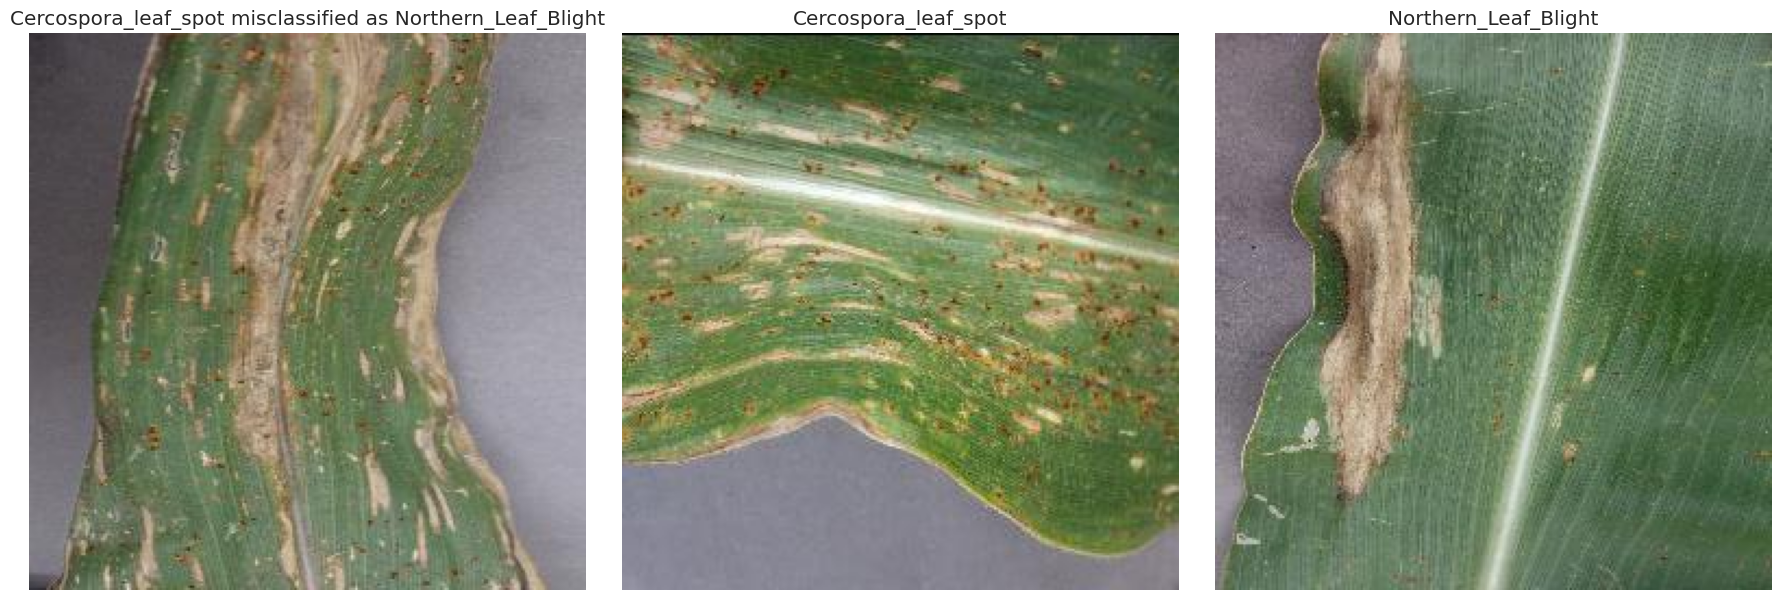

In [ ]:
#print the images we want to explain
import matplotlib.pyplot as plt

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the misclassified image
axes[0].imshow(miss_classified_images[14]['img'].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Cercospora_leaf_spot misclassified as Northern_Leaf_Blight')
axes[0].axis('off')

# Plot an image from class 7
axes[1].imshow(img_class_7.permute(1, 2, 0).cpu().numpy())
axes[1].set_title('Cercospora_leaf_spot')
axes[1].axis('off')

# Plot an image from class 9
axes[2].imshow(img_class_9.permute(1, 2, 0).cpu().numpy())
axes[2].set_title('Northern_Leaf_Blight')
axes[2].axis('off')

# Set the title for the entire figure

plt.tight_layout()
plt.show()

**Istructions to select the image**

1.   For misclassified image:
   
  image = miss_classified_instance \
  label = 7 \
  class_pred = 9
2.   For Image from class 7 (Cercospora_leaf_spot)

  image = img_class_7 \
  label = 7 \
  class_pred = 7

3.   For Image from class 7 (Northern_Leaf_Blight)

  image = img_class_9 \
  label = 9 \
  class_pred = 9

**Istruction to select the parameters of the models**

IntGrad: baseline='black'

GradCam: ConvLayer: [model.model.features[5][0].block[1][0]]

GradCam++: ConvLayer: [model.model.features[5][0].block[1][0]]

In [ ]:
#Select the image you want to explain

image = miss_classified_instance
label = 7
class_pred = 9

#image = img_class_7
#label = 7
#class_pred = 7

#image = img_class_9
#label = 9
#class_pred = 9

#CASE 2: Non-Homogeneous Background

In [ ]:
# Images with  NON-HOMOGENEOUS BACKGROUND
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Strawberry___Leaf_scorch/4e3d5499-017b-4de5-8087-d7f94caec399___RS_L.Scorch 9914.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Strawberry___Leaf_scorch/70c7d7ed-2ca9-41f4-a19a-864e20f5bbb8___RS_L.Scorch 9977_flipLR.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Strawberry___Leaf_scorch/5374828c-87b2-4ef9-a492-9a786092169d___RS_L.Scorch 9938_flipLR.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Strawberry___Leaf_scorch/30e43c7d-0621-4827-8a3a-3ae771996f1e___RS_L.Scorch 9959.JPG' # immagine del bastoncino


# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

In [ ]:
# RED PIGMENT

#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Grape___healthy/0708190e-d6a1-4186-8428-1cd816419bfd___Mt.N.V_HL 9017_180deg.JPG'

# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

# Change Image by inserting red pigment
import random
num_pixels_to_change = 600 # Number of pixels to change to red

# Generate random coordinates for the pixels to be changed
random_coordinates = [(random.randint(0, 255), random.randint(0, 255)) for _ in range(num_pixels_to_change)]

# Change the randomly selected pixels to red
for coord in random_coordinates:
    x, y = coord
    image[:, x, y] = torch.tensor([1.0, 0.0, 0.0])

#CASE 3: Low Confidence Predictions

In [ ]:
'''
# Get Images with Low Confidence of prediction
low_confidence_images = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

with torch.no_grad():
    for path_index, image_lbl in tqdm(enumerate(valid_dl)):
        path_index_start = path_index * batch_size
        image, label = image_lbl
        image, label = image.to(device), label.to(device)
        probs = model(image)
        probs = torch.nn.functional.softmax(probs, dim=1)
        classes = torch.argmax(probs, dim=1)
        confidence = torch.max(probs, dim=1).values
        low_idx = torch.where(confidence <= 0.7, 1, 0).nonzero() # 0.7 is the threshold
        for i in low_idx:
            i = int(i)
            if int(classes[i]) == int(label[i]): # Check for the correct predictions
              image_path, _ = valid_dl.dataset.samples[path_index_start + i]
              low_confidence_images.append({"img_path": image_path, "prediction": int(classes[i]), "label": int(label[i]), "confidence": float(torch.max(probs[i,:]))})

print(len(low_confidence_images))

# Save the list with low confidence images metadata
import json
file_path = "/content/drive/MyDrive/XAI_Project/Data/Output/Low_confidence_prediction.json"
file = open(file_path, "w") # Save Data
json.dump(low_confidence_images, file)
file.close()
'''

In [ ]:
# Import Low Confidence Image Metadata
import json
file_path = "/content/XAI_PhD_prj/json/Low_confidence_prediction.json"
with open(file_path, 'r') as file:
    # Load the JSON data
    low_conf_metadata = json.load(file)

In [ ]:
idx = 25 # Select images by index (e.g., 7, 10, 54)
image_path = low_conf_metadata[idx]['img_path'] # get the image path

# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

New Plant Diseases Dataset(Augmented)/valid/Pepper,_bell___Bacterial_spot/4d42924a-13e0-4e26-b131-2125e154c542___NREC_B.Spot 9220.JPG


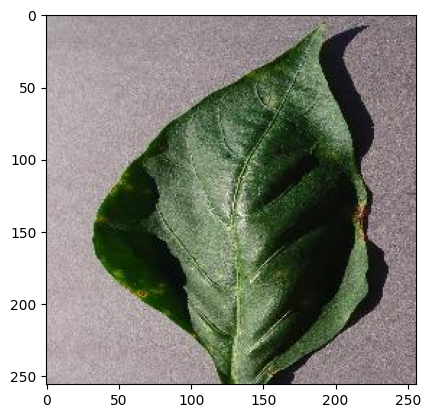

In [ ]:
import matplotlib.pyplot as plt

print(image_path)
plt.imshow(Image.open(image_path))

# CASE 4: High Confidence Predictions




In [ ]:
'''
# Get Images with Low Confidence of prediction
high_confidence_images = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

with torch.no_grad():
    for path_index, image_lbl in tqdm(enumerate(valid_dl)):
        path_index_start = path_index * batch_size
        image, label = image_lbl
        image, label = image.to(device), label.to(device)
        probs = model(image)
        probs = torch.nn.functional.softmax(probs, dim=1)
        classes = torch.argmax(probs, dim=1)
        confidence = torch.max(probs, dim=1).values
        low_idx = torch.where(confidence >= 0.93, 1, 0).nonzero() # 0.93 is the threshold
        for i in low_idx:
            i = int(i)
            if int(classes[i]) == 14: # Check for the correct predictions of Grape Healty (14)
              image_path, _ = valid_dl.dataset.samples[path_index_start + i]
              high_confidence_images.append({"img_path": image_path, "prediction": int(classes[i]), "label": int(label[i]), "confidence": float(torch.max(probs[i,:]))})

print(len(high_confidence_images))

# Save the list with low confidence images metadata
import json
file_path = "/content/drive/MyDrive/XAI_Project/Data/Output/High_confidence_prediction_Grape_Healthy.json"
file = open(file_path, "w") # Save Data
json.dump(high_confidence_images, file)
file.close()
'''

In [ ]:
# Import Low Confidence Image Metadata
import json
file_path = "/content/XAI_PhD_prj/json/High_confidence_prediction_Grape_Healthy.json"
with open(file_path, 'r') as file:
    # Load the JSON data
    low_conf_metadata = json.load(file)

In [ ]:
idx = 0 # Select images by index (e.g., 0, 1)
image_path = high_conf_metadata[idx]['img_path'] # get the image path

# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

# CASE 5: Similar Images

In [ ]:
# SIMILAR IMAGES of Early Blight
image_path = 'New Plant Diseases Dataset(Augmented)/valid/Potato___Early_blight/2fe81ef1-d7ec-4395-b071-c74d5beb4037___RS_Early.B 7242.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Potato___Early_blight/3e7543bc-4792-4b65-afd9-f9ccd52b7319___RS_Early.B 8571.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Potato___Early_blight/3ef2279b-2fda-463a-b007-e2a93ff977f0___RS_Early.B 7235.JPG'

# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

# CASE 6: Images with multiple leaves

In [14]:
#Images with multiple leaves:
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy/1dae303e-6545-4c87-8c95-8805108f5282___RS_HL 0437_180deg.JPG'
#image_path = 'New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy/3df51cfe-b583-40ae-a2d5-d4928a8a763f___RS_HL 9765_180deg.JPG'
image_path = 'New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy/3ca6e178-acee-4463-9d9f-aa1636eb9df6___RS_HL 0306_180deg.JPG'

# call the dictionary over a path to get the label
label = dict_path_to_class[image_path]

# import the image using the path
from PIL import Image
image = Image.open(image_path)
convert_tensor = transforms.ToTensor() # convert to image to tensor
image = convert_tensor(image)

#Select Image
Select an image before applying XAI techniques.

Label: Tomato___healthy(37) 
Prediction: Tomato___healthy(37) 
Confidence: 0.918


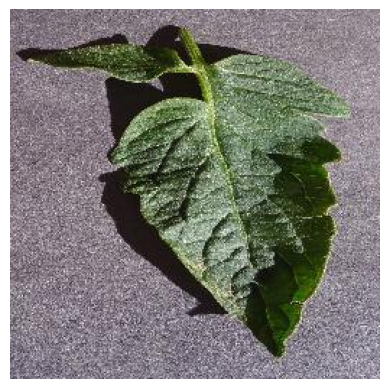

In [ ]:
#Select the image you want to explain and its label
#image = image_to_explain
#label = label_associated_to_the_image (ground truth)

# convert image to numpy array for later visualization
np_image = image.numpy() if not isinstance(image, np.ndarray) else image

probs = model(image.unsqueeze(0).float().to(device)) # pass to the model
class_pred = torch.argmax(probs, dim=1).item()
probs = torch.nn.functional.softmax(probs, dim=1)
confidence = torch.max(probs, dim=1).values.item()
print(f"Label: {idx_to_disease[label]}({label}) \nPrediction: {idx_to_disease[class_pred]}({class_pred}) \nConfidence: {round(confidence,3)}")
plt.imshow(image.permute(1, 2, 0).numpy())
#plt.savefig(f"/content/drive/MyDrive/XAI_Project/Data/Output/Similar_Image_2.png", bbox_inches='tight') # save fig
plt.axis('off')
plt.show()

# Apply XAI Techniques
Apply XAI methods one by one.

## IntGrad

In [ ]:
from XAI_course_2024.xailib.explainers.intgrad_explainer import IntgradImageExplainer

model = model.to(device)
ig = IntgradImageExplainer(model) #Create the Explainer
ig.fit() #Fit the Explainer

#Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.from_numpy(image).float() if not isinstance(image, torch.Tensor) else image

#Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return torch.nn.functional.softmax(model(image.unsqueeze(dim=0).to(device)), dim=1)

#Explain the Instances
intgrad_pt_score = ig.explain(image=image, index_to_explain=class_pred, baseline='black', preprocessing=preprocessing, predict=predict,
                              model_type='pytorch', cuda=device=="cuda")

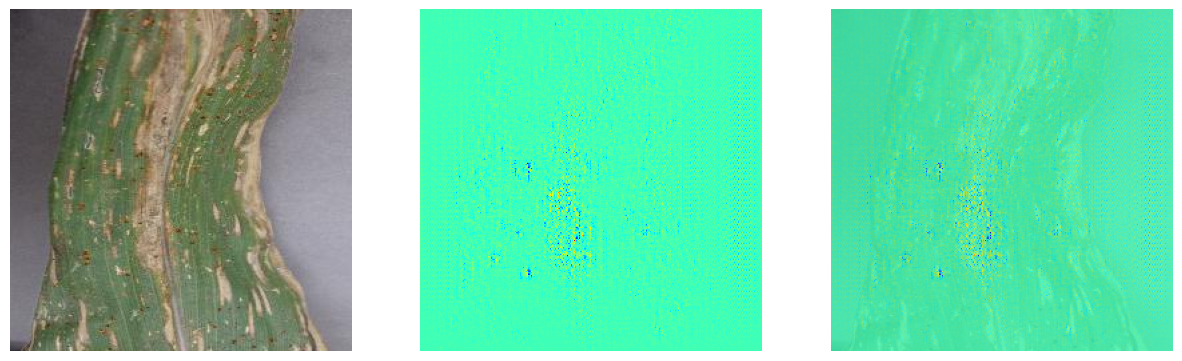

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).numpy()); ax[0].axis('off')
ax[1].imshow(np.sum(intgrad_pt_score, axis=-1), cmap='jet'); ax[1].axis('off')
ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).numpy(), alpha=1); ax[2].axis('off')
ax[2].imshow(np.sum(intgrad_pt_score, axis=-1), cmap='jet', alpha=0.8)

##Lime

In [ ]:
!pip install lime

In [ ]:
from XAI_course_2024.xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

model = model.to(device)
lm = LimeXAIImageExplainer(model) # 1) Create the Explainer
lm.fit() # 2a) Fit the Explainer

# 2b) Create custom classifier function if not predict
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images, num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    with torch.no_grad():
        #images = torch.tensor(images/255).permute(0,3,1,2).float()
        images = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        pred = torch.nn.functional.softmax(model(images.to(device)), dim=1).cpu().detach().numpy()
        return pred

  0%|          | 0/1000 [00:00<?, ?it/s]

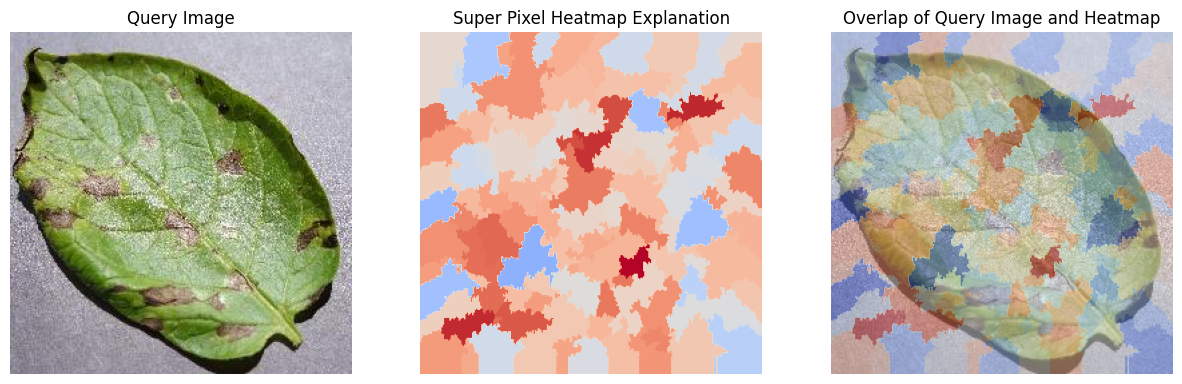

In [ ]:
# 3) Explain an Instance
explanation = lm.explain((preprocessing(np_image).permute(1, 2, 0).numpy() * 255).astype(int), classifier_fn, num_samples=1000)

# 4) Plot the results
lm.plot_lime_values(preprocessing(np_image).permute(1, 2, 0).numpy(), explanation)
lime_score = explanation.heatmap

## RISE

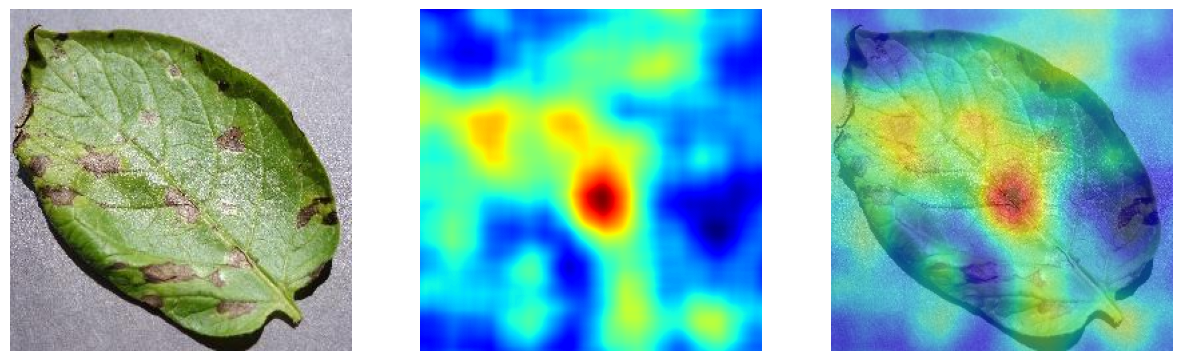

In [ ]:
from XAI_course_2024.xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size

    def predict(self, X):
        with torch.no_grad():
            images = torch.tensor(X).permute(0, 3, 1, 2).float()
            return torch.nn.functional.softmax(model(images.to(device)), dim=1).cpu().detach().numpy()

model = model.to(device)
rise_model = Rise_model_wrapper(model, (np_image.shape[1], np_image.shape[1]))
rise = RiseXAIImageExplainer(rise_model)

N = 1000  # number of random masks
s = 10  # cell_size = input_shape / s
p1 = 0.5  # masking probability
pred = class_pred

rise.fit(N, s, p1)

sal = rise.explain(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy())
rise_score = sal[pred, :]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[pred, :], cmap='jet')
ax[1].axis('off')

ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[2].imshow(sal[pred, :], cmap='jet', alpha=0.5)
ax[2].axis('off');

## GradCAM

In [ ]:
! pip install ttach

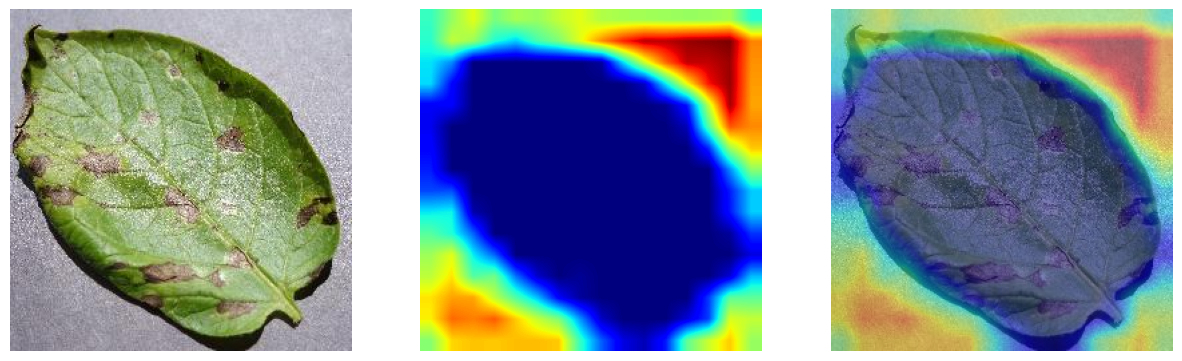

In [ ]:
from XAI_course_2024.xailib.explainers.gradcam_explainer import GradCAMImageExplainer

model = CustomEfficientNet.load_from_checkpoint("/content/XAI_PhD_prj/checkpoints/efficient_net_scratch-v15.ckpt")
model = model.to(device)
explainer = GradCAMImageExplainer(model)
explainer.fit([model.model.features[4][0].block[1][0]])  # select the convolutional Layer
pred = class_pred
attr = explainer.explain(preprocessing(np_image).to(device).unsqueeze(0), pred, model_type='pytorch')
gradcam_pt_score = attr[0, :]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(attr[0, :], cmap='jet')
ax[1].axis('off')
ax[2].imshow(preprocessing(np_image).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
ax[2].imshow(attr[0, :], cmap='jet', alpha=0.5)
ax[2].axis('off');


## GradCAM plus

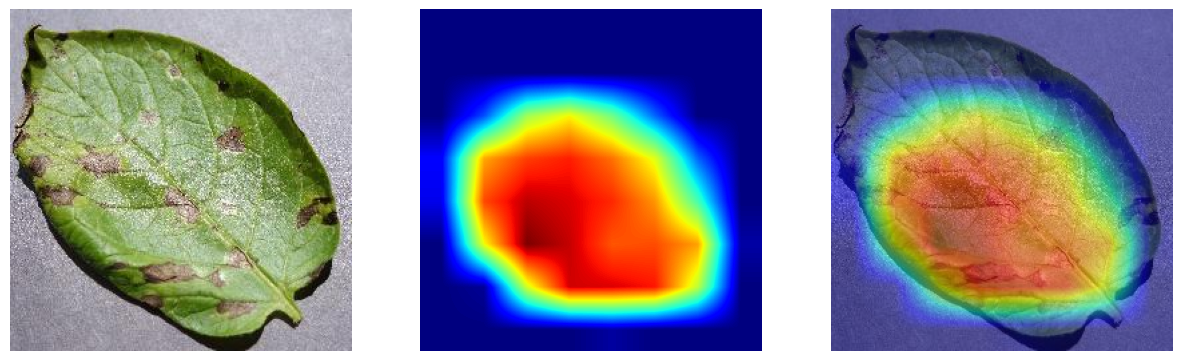

In [ ]:
from XAI_course_2024.xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

explainer = GradCAMPlusPlusImageExplainer(model)
explainer.fit([model.model.features[7][0].block[1][0]])
pred = class_pred
attr = explainer.explain(preprocessing(image).to(device).unsqueeze(0), pred, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].imshow(preprocessing(image).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[0].axis('off')
ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')
ax[2].imshow(preprocessing(image).permute(1,2,0).cpu().detach().numpy(),cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

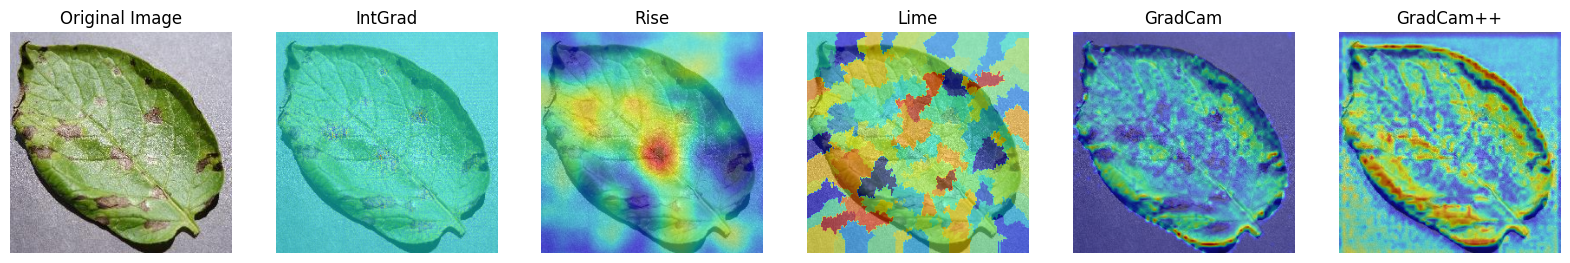

In [ ]:
# Combine the Saliency maps all together.
import matplotlib.pyplot as plt
import numpy as np

# Combine the visualizations of all methods
plt.figure(figsize=(20, 5))

# Plotting the original image
plt.subplot(1, 6, 1)
plt.imshow(np.transpose(np_image, (1, 2, 0)), cmap='gray')
plt.title('Original Image')
plt.axis(False)

# Plotting the heatmaps
methods = [np.sum(intgrad_pt_score, axis=-1), rise_score, lime_score, gradcam_pt_score, gradcampp_pt_score]
method_names = ['IntGrad', 'Rise', 'Lime', 'GradCam', 'GradCam++']
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(np.transpose(np_image, (1, 2, 0)), cmap='gray')
    plt.imshow(methods[i], cmap='jet', alpha=0.5)
    plt.title(method_names[i])
    plt.axis(False)

#plt.savefig(f"/content/drive/MyDrive/XAI_Project/Data/Output/Similar_Image_Saliency_1.png", bbox_inches='tight') # save fig
plt.show()


## SHAP

In [10]:
!pip install shap --quiet
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 12.0 MB/s eta 0:00:00


In [11]:
shap_dl = DataLoader(valid, batch_size=256, num_workers=4, pin_memory=True, persistent_workers=True, shuffle=True)
iter_valid_shap_dl = iter(shap_dl)
dl_img, dl_lbl = next(iter_valid_shap_dl)
model = model.to(device)
dl_img = dl_img.to(model.device)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


### Explain entire Net

In [12]:
def predict_shap(image):
    img = image if isinstance(image, torch.Tensor) else torch.from_numpy(image)
    img = img.to(model.device)
    img = img.permute(0, 3, 1, 2)
    preds = model(img)
    return preds

In [15]:
topk = 2
batch_size = 128
n_evals = 1e4
# define a masker that is used to mask out partitions of the input image.
# mask_value : np.array, "blur(kernel_xsize, kernel_xsize)", "inpaint_telea", or "inpaint_ns"
masker_blur = shap.maskers.Image("blur(128, 128)", image.permute(1, 2, 0).shape)

# create an explainer with model and image masker
# algorithm: "auto", "permutation", "partition", "tree", or "linear"
explainer = shap.Explainer(predict_shap, masker_blur, output_names=[str(i) for i in range(len(valid.classes))], algorithm="auto")

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    image.permute(1, 2, 0).unsqueeze(0),
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998.0 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:54, 54.58s/it]               


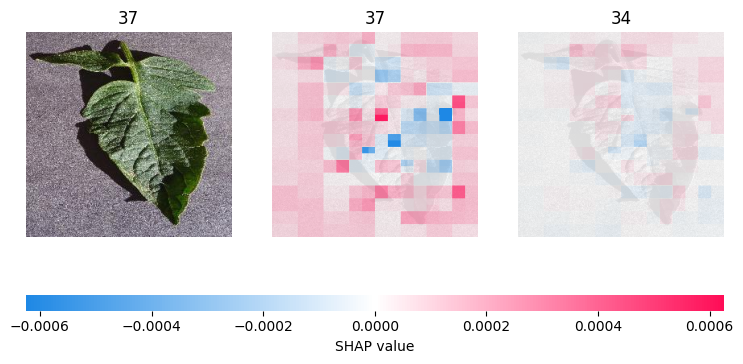

In [17]:
shap_data = shap_values.data.cpu().numpy()[0]
orig_shap_val = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]
shap.image_plot(
    shap_values=orig_shap_val,
    pixel_values=shap_data,
    labels=shap_values.output_names,
    true_labels=[label]
)

### Explain a layer (may not work on Colab)

In [ ]:
e = shap.GradientExplainer((model, model.model.features[4][0].block[1][0]), dl_img)#, local_smoothing=0.1)
shap_values, indexes = e.shap_values(
    image.unsqueeze(0).to(model.device), ranked_outputs=2, nsamples=1000
)
#get the names for the classes
index_names = np.vectorize(lambda x: str(int(x)))(indexes.cpu())
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1).squeeze(0) for s in shap_values]
# plot the explanations
np_image = image.to("cpu").permute(1, 2, 0).numpy()

shap.image_plot(shap_values, np_image, index_names)

# Metric analysis

In [ ]:
from XAI_course_2024.xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    with torch.no_grad():
        pred = torch.nn.functional.softmax(model.forward(torch.tensor(image).to(device)),dim=1)
        return pred

step = 256
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

/content/XAI_course_2024/xailib/metrics/insertiondeletion.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(img))
/content/XAI_course_2024/xailib/metrics/insertiondeletion.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))


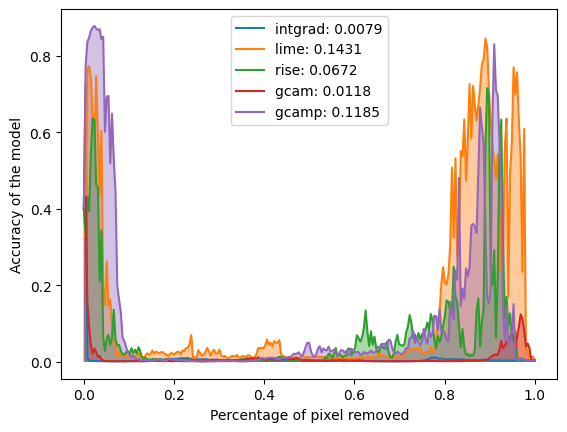

In [ ]:
from sklearn.metrics import auc

y_int = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, intgrad_pt_score, rgb=True)
y_rise = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, rise_score, rgb=True)
y_lime = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, lime_score, rgb=True)
y_gcam = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcam_pt_score, rgb=True)
y_gcamp = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcampp_pt_score, rgb=True)
x = np.arange(len(y_int))/(step*step)*step
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend()
#plt.savefig("/content/drive/MyDrive/XAI_Project/Data/Output/Low_Conf_Image_Metric_Del.png", bbox_inches='tight') # save fig

<ipython-input-30-b45175356806>:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-30-b45175356806>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()


(-0.5, 255.5, 255.5, -0.5)

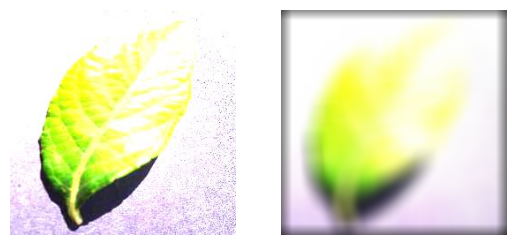

In [ ]:
import torch.nn as nn
from scipy.ndimage.filters import gaussian_filter
CH = 3
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=25, ksig=25):
    kern = gkern(klen, ksig)
    image = torch.tensor(image).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)

F,ax = plt.subplots(1,2)
ax[0].imshow(preprocessing(image).permute(1,2,0).numpy(), cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(preprocessing(image)).permute(1,2,0),cmap='gray')
ax[1].axis(False)

In [ ]:
from XAI_course_2024.xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    with torch.no_grad():
        pred = torch.nn.functional.softmax(model.forward(torch.tensor(image).to(device)),dim=1)
        return pred

step = 256
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

/content/XAI_course_2024/xailib/metrics/insertiondeletion.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(img))
<ipython-input-30-b45175356806>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()
/content/XAI_course_2024/xailib/metrics/insertiondeletion.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(self.predict(start.numpy()))


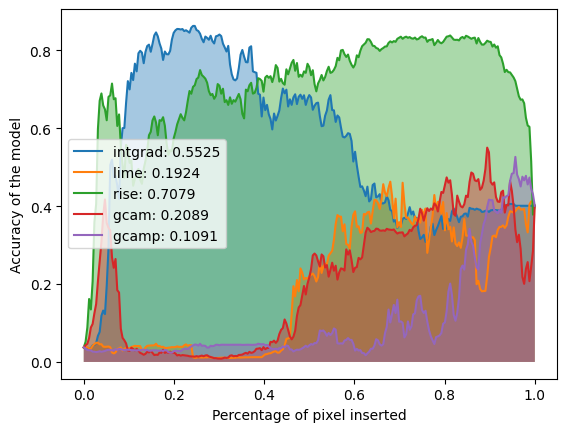

In [ ]:
from sklearn.metrics import auc

y_int = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, intgrad_pt_score, rgb=True)
y_rise = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, rise_score, rgb=True)
y_lime = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, lime_score, rgb=True)
y_gcam = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcam_pt_score, rgb=True)
y_gcamp = metric(preprocessing(np_image).unsqueeze(0).numpy(), step, gradcampp_pt_score, rgb=True)
x = np.arange(len(y_int))/(256*256)*step
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel inserted')
plt.ylabel('Accuracy of the model')
plt.legend()
#plt.savefig("/content/drive/MyDrive/XAI_Project/Data/Output/Low_Conf_Image_Metric_Insert.png", bbox_inches='tight') # save fig